In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

ae_dir = os.path.join(project_dir, 'modules/AutoEncoder')
if ae_dir not in sys.path:
    sys.path.append(ae_dir)

from matplotlib import pyplot as plt 
import numpy as np
import torch
import config
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

In [4]:
from scipy.io import loadmat

dataset_path = os.path.join(config.DERMA_DATASET_DIR, 'train/')
subjects = os.listdir(dataset_path)[::12]

subject_data = []
for i in subjects:
    mat = loadmat(os.path.join(dataset_path, i))
    subject_data.append(mat['preProcessedImage'].astype(np.float64)[np.newaxis,:])

subject_data = np.concatenate(subject_data)
mean_value = subject_data[np.logical_not(np.isnan(subject_data))].mean()
subject_data = np.nan_to_num(subject_data, nan=mean_value)

### Endmember Extraction

In [5]:
n_endmembers = 4

#### NFINDR

In [58]:
from pysptools import eea

ee = eea.NFINDR()
U = torch.tensor(ee.extract(subject_data.reshape(subject_data.shape[0]*subject_data.shape[1], subject_data.shape[2], -1), n_endmembers, maxit=1024, normalize=False,ATGP_init=True))

#### VCA

In [19]:
from HySpecLab.eea import VCA

eea = VCA(n_endmembers)
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])
eea.fit(data)
U = torch.tensor(eea.endmembers())

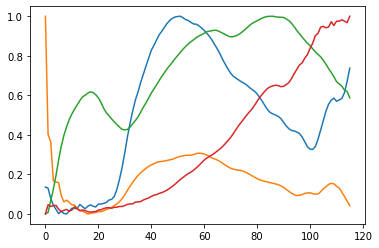

In [59]:
from matplotlib import pyplot as plt 
plt.plot(U.T)
plt.show()

In [21]:
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode, Normalize

transform = Compose([
    ToTensor(),
    Resize((64,64), InterpolationMode.NEAREST),
])

In [22]:
from torch.utils.data import Dataset 
from torchvision import transforms as torchTransforms

class AuxDataset(Dataset):
    def __init__(self, data, transform=torchTransforms.Compose([torchTransforms.ToTensor()])):
        super(AuxDataset, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

train_set = AuxDataset(subject_data, transform)

In [23]:
from torch.utils.data import DataLoader

loader = DataLoader(train_set, batch_size=32, shuffle=False)
X_tensor = next(iter(loader))

In [42]:
from HySpecLab.unmixing import get_noise, NOISE_TYPE
noisy_input = get_noise(X_tensor.shape[1:], batch_size = X_tensor.shape[0], noise_type=NOISE_TYPE.uniform)

U_tensor = torch.unsqueeze(U.T, dim=0).float()

print('Z shape: {}'.format(noisy_input.shape))
print('HyperCube shape: {}'.format(X_tensor.shape))
print('Endmember shape: {}'.format(U_tensor.shape))

Z shape: torch.Size([5, 116, 64, 64])
HyperCube shape: torch.Size([5, 116, 64, 64])
Endmember shape: torch.Size([1, 116, 4])


In [47]:
from HySpecLab.unmixing import UnDIP

n_bands = X_tensor.shape[1]
n_endmembers = U_tensor.shape[-1]

dims = [n_bands, 256]
skip_connection = [0]
out_channels = 64

model = UnDIP(n_endmembers, out_channels, dims, skip_connection, dropout=False, batch_norm=True, activation_func=nn.ReLU())

100%|██████████| 15000/15000 [03:03<00:00, 81.61epoch/s, tls=0.0235]


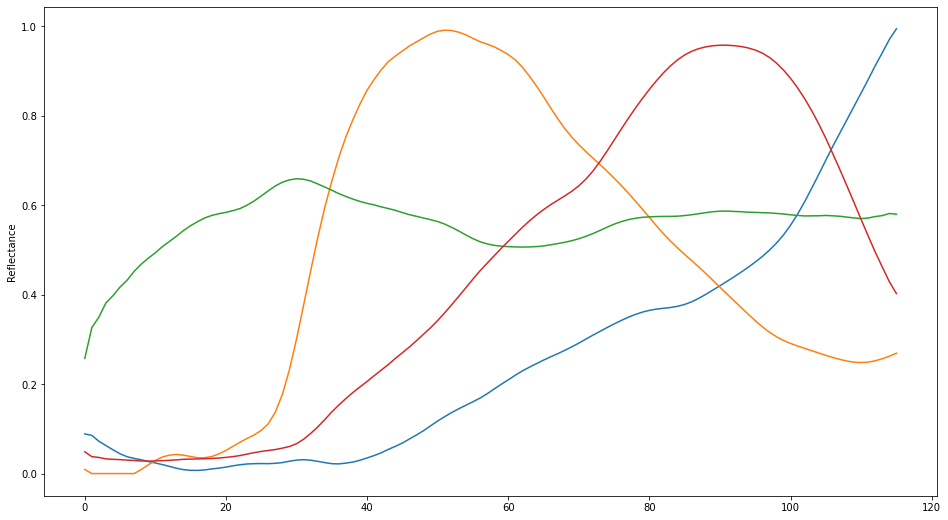

In [48]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from HySpecLab.utils import fig_to_image


batch_size = X_tensor.shape[0]
n_bands = X_tensor.shape[1]
w, h = X_tensor.shape[2:]

n_epoch = 15000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.MSELoss()

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

tb_writer = SummaryWriter('logs/test')

#Endmember signal image
fig, ax = plt.subplots(1,1, figsize=(16,9))

labels = list(map(lambda x: 'Endmember {}'.format(x), range(len(U))))
ax.plot(U.T, label=labels)
ax.set_ylabel('Reflectance')

image = ToTensor()(fig_to_image(fig)).unsqueeze(0)
tb_writer.add_image('Endmembers', image, dataformats='NCHW')


# Target Image
show_band_idx = np.linspace(0, X_tensor.shape[1]-1, num=16, dtype=np.int64)
for i in range(4):
    target_imgs = torch.unsqueeze(X_tensor[i, show_band_idx], dim=1)
    img_grid = make_grid(target_imgs)
    tb_writer.add_image('Target/{}'.format(i), img_grid, 0)


noisy_input = noisy_input.to(device)

for epoch in epoch_iterator:
    output = model(noisy_input)

    restoration = torch.matmul(U_tensor.to(device), output.flatten(start_dim=2)).reshape((output.shape[0], n_bands, w, h))

    if epoch % 100 == 0: # Cada 100 epoch
        for i in range(4):
            rest_imgs = torch.unsqueeze(restoration[i, show_band_idx], dim=1)
            img_grid = make_grid(rest_imgs)
            tb_writer.add_image('Output/{}'.format(i), img_grid, epoch)

            abundance_imgs = torch.unsqueeze(output[i], dim=1)
            img_grid = make_grid(abundance_imgs)
            tb_writer.add_image('Abundance/{}'.format(i), img_grid, epoch)

    batch_loss = criterion(restoration, X_tensor.float().to(device))

    epoch_iterator.set_postfix(tls="%.4f" % np.mean(batch_loss.detach().item()))
    tb_writer.add_scalar('Loss', batch_loss.detach().item(), epoch)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

In [60]:
A = model(noisy_input)

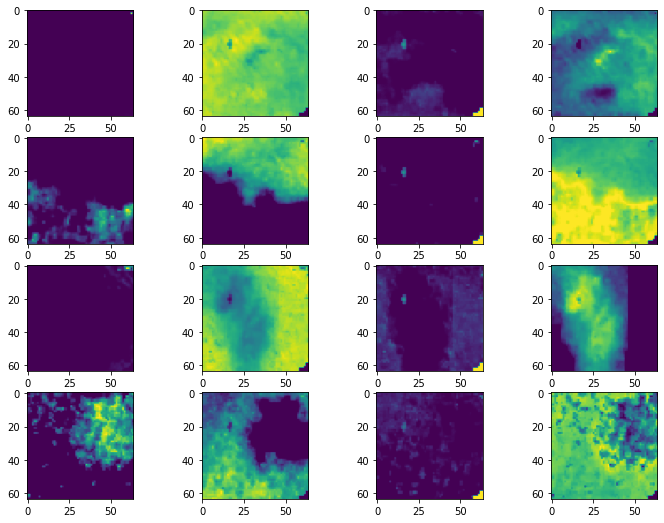

In [61]:
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt

A = A.cpu().detach()
fig, ax = plt.subplots(4,4, figsize=(12,9))
for i in range(len(A[0])):
    if i >= 4:
        break
    
    for j in range(len(A[1])):
        ax[i, j].imshow(A[i,j])

    